In [1]:
# 이미지 분할
# 필요한 이미지 다운로드

In [2]:
import urllib.request as req
import zipfile
def downloadImageFromUrl(url,filename,targetDir):
    with req.urlopen(url) as f:
        with open(targetDir+'/'+filename,'wb') as of:
            of.write(f.read())
    zipfile.ZipFile(targetDir+'/'+filename).extractall()           
    
# url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
# import urllib.request as req
# with req.urlopen(url) as f:
#     with open('jena_climate_2009_2016.csv.zip','wb') as of:
#         of.write(f.read())
# import zipfile
# zipfile.ZipFile('./jena_climate_2009_2016.csv.zip').extractall()        

In [3]:
url1 = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
url2= 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'

In [4]:
import os
os.mkdir('./image_segmentation')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './image_segmentation'

In [ ]:
# downloadImageFromUrl(url1,'images.tar.gz','./image_segmentation')
# zipfile.ZipFile('./image_segmentation/images.tar.gz').extractall()     
# !tar -xvzf './image_segmentation/images.tar.gz'

In [ ]:
# downloadImageFromUrl(url2,'annotations.tar.gz','./image_segmentation')

In [5]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'

In [6]:
pwd

'D:\\leeky_ai'

In [7]:
os.chdir('D:\leeky_ai\image_segmentation')

In [8]:
pwd

'D:\\leeky_ai\\image_segmentation'

In [9]:
input_img_paths = sorted(
    [os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')]    
)

In [10]:
import glob

In [11]:
target_paths =  glob.glob(target_dir+'/*.png')

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

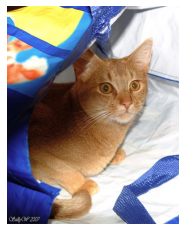

In [44]:
plt.imshow(load_img(input_img_paths[2]))
plt.axis('off')
plt.show()

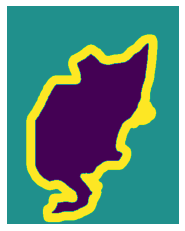

In [43]:
def display_target(target_arrary):
    normalized_array = (target_arrary.astype('uint8')-1)*127
    plt.axis('off')
    plt.imshow(normalized_array[:,:,0])
img = img_to_array(load_img(target_paths[2], color_mode='grayscale'))   
display_target(img)

In [33]:
temp = (img_to_array(load_img(target_paths[0], color_mode='grayscale')).astype('uint8')   -1)*127
temp[0,:,:]
target_paths[0]

'annotations/trimaps\\Abyssinian_1.png'

In [17]:
help(img_to_array)

Help on function img_to_array in module keras.utils.image_utils:

img_to_array(img, data_format=None, dtype=None)
    Converts a PIL Image instance to a Numpy array.
    
    Usage:
    
    ```python
    from PIL import Image
    img_data = np.random.random(size=(100, 100, 3))
    img = tf.keras.preprocessing.image.array_to_img(img_data)
    array = tf.keras.preprocessing.image.img_to_array(img)
    ```
    
    
    Args:
        img: Input PIL Image instance.
        data_format: Image data format, can be either `"channels_first"` or
          `"channels_last"`. Defaults to `None`, in which case the global
          setting `tf.keras.backend.image_data_format()` is used (unless you
          changed it, it defaults to `"channels_last"`).
        dtype: Dtype to use. Default to `None`, in which case the global setting
          `tf.keras.backend.floatx()` is used (unless you changed it, it
          defaults to `"float32"`).
    
    Returns:
        A 3D Numpy array.
    
    Raises

In [45]:
# 학습데이터
# 검증데이터
# 테스트 데이터

In [47]:
import numpy as np
import random
img_size = (200,200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path,target_size=img_size,color_mode='grayscale')        
    )
    img = img.astype('uint8')-1
    return img

In [48]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,)+ img_size + (1,), dtype='uint8')


In [50]:
num_imgs

7390

In [51]:
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [52]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [54]:
from tensorflow import keras
from tensorflow.keras import layers

In [55]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(64,3, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(128,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(128,3, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(256,3,strides=2, activation='relu', padding = 'same')(x)
    x = layers.Conv2D(256,3, activation='relu', padding = 'same')(x)
    
    x = layers.Conv2DTranspose(256,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256,3,activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128,3,activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64,3,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64,3,activation='relu', padding='same', strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation='softmax',padding='same')(x)
    
    model = keras.Model(inputs,outputs)
    return model

In [56]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [57]:
model.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets, 
                    epochs=50,callbacks=callbacks,batch_size=64,validation_data=(val_input_imgs,val_targets),verbose=1)

Epoch 1/50
  3/100 [..............................] - ETA: 30:56 - loss: 106.6865

KeyboardInterrupt: 